## Current step:
Select data augmentation policies using a controller model trained with Proximal Policy Optimization reinforcement learning.  

Be sure that the model is improving with training, and policies which resulted in lower accuracy are less likely to be chosen.


# AutoAugment with Proximal Policy Optimization



In [0]:
from keras import models, layers, backend, initializers
import time

import PIL
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras import datasets
from keras.utils import to_categorical
np.random.seed(42)
(XtrainFull, ytrainFull), (Xtest, ytest) = datasets.cifar10.load_data()
ix = np.arange(len(XtrainFull))
np.random.shuffle(ix)
Xtrain = XtrainFull[ix[:4000]]
ytrain = ytrainFull[ix[:4000]]
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)


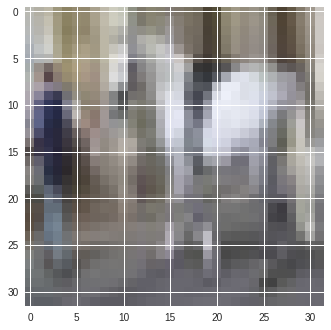

In [0]:
plt.imshow(Xtrain[0])

## Define Image Transformations

In [0]:
# Code below adapted from augmentation_transforms.py
# Modified to support transforms at the image class level
# Original copywright below:
# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
IMAGE_SIZE = 32
MEANS = [0.49139968, 0.48215841, 0.44653091]
STDS = [0.24703223, 0.24348513, 0.26158784]
PARAMETER_MAX = 10  # What is the max 'level' a transform could be predicted
#def pil_wrap(img):
#  """Convert the `img` numpy tensor to a PIL Image."""
#  return PIL.Image.fromarray(
#      np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')
#def pil_unwrap(pil_img):
#  """Converts the PIL img to a numpy array."""
#  pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
#  i1, i2 = np.where(pic_array[:, :, 3] == 0)
#  pic_array = (pic_array[:, :, :3] - MEANS) / STDS
#  pic_array[i1, i2] = [0, 0, 0]
#  return pic_array


def pil_wrap(X):
  X = X.reshape(32, 32, 3)
  X = np.uint8(X)
  return PIL.Image.fromarray(X)
def pil_unwrap(img):
  X = np.array(img.getdata()).reshape(32, 32, 3).astype(float)
  return X

# modified from https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
def create_cutout_mask(img_height, img_width, num_channels, size):
  """Creates a zero mask used for cutout of shape `img_height` x `img_width`.
  Args:
    img_height: Height of image cutout mask will be applied to.
    img_width: Width of image cutout mask will be applied to.
    num_channels: Number of channels in the image.
    size: Size of the zeros mask.
  Returns:
    A mask of shape `img_height` x `img_width` with all ones except for a
    square of zeros of shape `size` x `size`. This mask is meant to be
    elementwise multiplied with the original image. Additionally returns
    the `upper_coord` and `lower_coord` which specify where the cutout mask
    will be applied.
  """
  assert img_height == img_width
  # Sample center where cutout mask will be applied
  height_loc = np.random.randint(low=0, high=img_height)
  width_loc = np.random.randint(low=0, high=img_width)
  # Determine upper right and lower left corners of patch
  upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
  lower_coord = (min(img_height, height_loc + size // 2),
                 min(img_width, width_loc + size // 2))
  mask_height = lower_coord[0] - upper_coord[0]
  mask_width = lower_coord[1] - upper_coord[1]
  assert mask_height > 0
  assert mask_width > 0
  mask = np.ones((img_height, img_width, num_channels))
  zeros = np.zeros((mask_height, mask_width, num_channels))
  mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (
      zeros)
  return mask, upper_coord, lower_coord
def cutout_numpy(img, size=16):
  """Apply cutout with mask of shape `size` x `size` to `img`.
  The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
  This operation applies a `size`x`size` mask of zeros to a random location
  within `img`.
  Args:
    img: Numpy image that cutout will be applied to.
    size: Height/width of the cutout mask that will be
  Returns:
    A numpy tensor that is the result of applying the cutout mask to `img`.
  """
  img_height, img_width, num_channels = (img.shape[0], img.shape[1],
                                         img.shape[2])
  assert len(img.shape) == 3
  mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
  return img * mask
def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / PARAMETER_MAX
def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / PARAMETER_MAX)
def _cutout_pil_impl(pil_img, level):
  """Apply cutout to pil_img at the specified level."""
  size = int_parameter(level, 20)
  if size <= 0:
    return pil_img
  img_height, img_width, num_channels = (32, 32, 3)
  _, upper_coord, lower_coord = (
      create_cutout_mask(img_height, img_width, num_channels, size))
  pixels = pil_img.load()  # create the pixel map
  for i in range(upper_coord[0], lower_coord[0]):  # for every col:
    for j in range(upper_coord[1], lower_coord[1]):  # For every row
      pixels[i, j] = (125, 122, 113, 0)  # set the colour accordingly
  return pil_img
def _enhancer_impl(enhancer):
  """Sets level to be between 0.1 and 1.8 for ImageEnhance transforms of PIL."""
  def impl(pil_img, level):
    v = float_parameter(level, 1.8) + .1  # going to 0 just destroys it
    return enhancer(pil_img).enhance(v)
  return impl
# =============================================================================
def ShearX(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))
  
def ShearY(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))  
  
def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))
def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))
def Rotate(img, v):  # [-30, 30]
    v = int_parameter(v, 30)
    if np.random.random() > 0.5:
      v = -v
    return img.rotate(v)
def AutoContrast(img, _):
    #return PIL.ImageOps.autocontrast(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.autocontrast(img)
def Invert(img, _):
    #return PIL.ImageOps.invert(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.invert(img)
def Equalize(img, _):
    #return PIL.ImageOps.equalize(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.equalize(img)
def Flip_LR(img, _):  # not from the paper
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
def Flip_UD(img, _):
    return img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
  
def Solarize(img, v):  # [0, 256]
    v = int_parameter(v, 256)
    #return PIL.ImageOps.solarize(img.convert('RGB'), 256 - v).convert('RGBA')
    return PIL.ImageOps.solarize(img, 256 - v)
def Posterize(img, v):  # [4, 8]
    v = int_parameter(v, 4)
    #return PIL.ImageOps.posterize(img.convert('RGB'), 4 - v).convert('RGBA')
    return PIL.ImageOps.posterize(img, 4 - v)
def Contrast(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Contrast)(img, v)
def Blur(img, v):
    return img.filter(PIL.ImageFilter.BLUR)
  
def Color(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Color)(img, v)
def Smooth(img, v):
    return img.filter(PIL.ImageFilter.SMOOTH)
  
def Brightness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Brightness)(img, v)
def Sharpness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Sharpness)(img, v)
def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    return _cutout_pil_impl(img, v)
def Crop(img, v, interpolation=PIL.Image.BILINEAR):
    cropped = img.crop((v, v, IMAGE_SIZE - v, IMAGE_SIZE - v))
    resized = cropped.resize((IMAGE_SIZE, IMAGE_SIZE), interpolation)
    return resized
def Identity(img, v):
  return img
  
opmap = {
    'Flip_LR' : Flip_LR,
    'Flip_UD' : Flip_UD,
    'AutoContrast' : AutoContrast,
    'Equalize' : Equalize,
    'Invert' : Invert,
    'Rotate' : Rotate,
    'Poserize' : Posterize,
    'Crop' : Crop,
    'Solarize' : Solarize,
    'Color' : Color,
    'Contrast' : Contrast,
    'Brightness' : Brightness,
    'Sharpness' : Sharpness,
    'ShearX' : ShearX,
    'ShearY' : ShearY,
    'TranslateX' : TranslateX,
    'TranslateY' : TranslateY,
    'Cutout' : Cutout,
    'Blur' : Blur,
    'Smooth' : Smooth
    
}

## Define Operation, Subpolicy classes, autoaugment generator

In [0]:
class Operation:
  def __init__(self, transformation, p = 0.5, magnitude=5):
      self.prob = p
      self.magnitude = magnitude
      self.transformation = transformation
      self.name = str(transformation).split(' ')[1]
  def __call__(self, X, y):
    """
    Takes a list of numpy arrays, and one at a time:
      converts to PIL image
      With self.probability chance, apply self.transformFunction
      with magnitude self.magnitude.
    Converts back to numpy array
    Returns the new list of np.arrays
    """
    transformed = []
    for x in X:
      if np.random.rand() < self.prob:
        pilX = PIL.Image.fromarray(x)
        pilX = self.transformation(pilX, self.magnitude)
        x = np.array(pilX)
      transformed.append(x)
    return np.array(transformed)
      
  def __str__(self):
    return '%s (P=%.3f, M=%.3f)' % (self.name,
                                    self.prob,
                                    self.magnitude)    
class Subpolicy:
    def __init__(self, operations):
        self.operations = operations
    def __call__(self, X, Y):
        for op in self.operations:
            X = op(X, Y)
        return X
    def __str__(self):
      ret = ''
      for op in self.operations:
        ret += str(op) + '\n'
      return ret[:-1]
      
def autoaugment(policy, X, y, batch_size):
    while True:
        ix = np.arange(len(X))
        np.random.shuffle(ix)
        for i in range(len(X) // batch_size):
            _ix = ix[i*batch_size:(i+1)*batch_size]
            _X = X[_ix]
            _y = y[_ix]
            if 0 != len(policy):
              subpolicy = np.random.choice(policy)
              _X = subpolicy(_X, _y)
            yield _X, _y

## Display the transformations
### (Just to see what they look like)

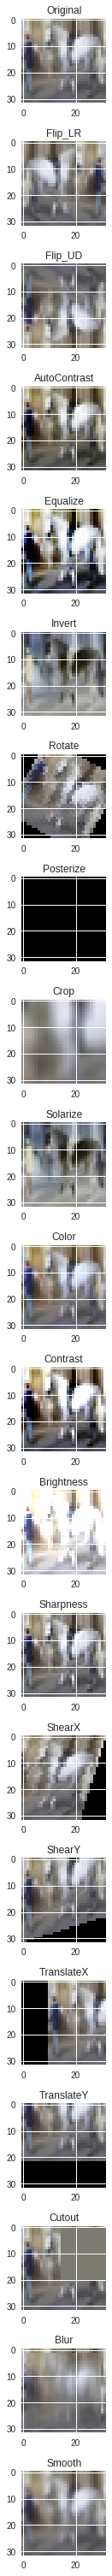

In [0]:
plt.figure(figsize=[2,2*(len(opmap)+1)])
plt.subplot(len(opmap)+1, 1, 1)
plt.imshow(Xtrain[0])
plt.title('Original')
for i, op in enumerate(opmap.values()):
  oper = Operation(op, 1., magnitude=10)
  newX = oper(Xtrain[0:1], ytrain[0:1])[0]
  plt.subplot(len(opmap)+1, 1, i+2)
  plt.title(oper.name)
  plt.imshow(newX)
plt.tight_layout()

In [0]:
from keras import models, layers, initializers
import tensorflow as tf

    
class Controller():
  
    def __init__(self, lstmUnits=100, minibatchSize=8, lr=1e-2, epsilon = .2,
                nSubpolicies=5, nOpsPerSubpolicy=2,
                transforms={}, nProbabilities=6, nMagnitudes=5):

      """
      Controller object which generates transformation policies,
      sets of subpolicies each of which contain transform operations
      
      Consists of a neural net which takes a constant "dummy" input state
      Feeds through a LSTM, then a set of parallel dense layers with
      softmax activation.  Each dense layer corresponds with a decision
      in selecting the policy: A transform type, probability, and magnitude
      for each Operation
      
      Args:
      
      lstmUnits: The output dimension of the LSTM encoder
      
      minibatchSize: How many times to sample policies and train a child model
                     before fitting based on those sample policy/accuracy
                     pairs
      lr: Learning rate for the controller net
      
      nSubpolicies:  The number of different subpolicies to generate
      
      nOpsPerSubpolicy: The number of operations in each subpolicy
      
      transforms: a list tuples identifying the possible image transformations
                  each representing (function, minMagnitude, maxMagnitude)

      nProbabilities: How many evenly-spaced discrete probability values will 
                      be considered: 11 means that each operation will have a 
                      0%, 10%, 20% ... 80%, 90%, or 100% of being applied.
                      
      nMagnitudes: How many evenly-spaced discrete magnitude values will be
                   considered for each operation. This will mean different
                   things to different operations
                   
      """
      self.lstmUnits = 100
      self.minibatchSize = minibatchSize
      self.lr = lr
      self.nSubpolicies = nSubpolicies
      self.nOpsPerSubpolicy = nOpsPerSubpolicy
      self.transforms = transforms
      self.nTransforms = len(transforms)
      self.nProbabilities = nProbabilities
      self.nMagnitudes = nMagnitudes
      self.softmaxCache = None
      self.epsilon = tf.constant(epsilon, dtype=tf.float32)
      self.buildModel()
      
    def buildModel(self):

      """
      Builds the neural net to generate policy probabilities.
      
      Each forward pass produces 3 softmax for each operation:
      Operation Type, Probability, Magnitude.
      Each subpolicy has self.nOpsPerSubpolicy such Operations, and each
      policy has self.nSubpolicies such subpolicies.

      To set the loss we want to minimize, we need the following placeholders,
      which are given in feedDict each training step:
        selectionMask_ph: Binary mask for each softmax layer indicating which 
          operation type, probability, and magnitude was selected for each
          Operation in each Subpolicy. 
          All concatenated together to match the shape of the concatSoftmaxes

        score_ph: Single score for each sample
        
        pSelection_ph: the chance of the previous model selecting this exact
          policy. This is used in the clipped surrogate objective function, 
          as part of the ratio 
          p(selection | old weights) / p(selection | new weights)
          
          This ratio is clipped between (1-epsilon, 1+epsilon) and multiplied
          by the advantage function (score_ph in this case) to form the loss
          
          

      Each training step, we apply the selectionMask_ph to the concatSoftmaxes,
      so backprop will only update the weights leading to the subpolicy choices
      made in this particular step.  These are multiplied by the 
      score we pass, and we create an optimizer to maximize the mean of this
      tensor. (well, minimize for negative score)

      If the model did well, we pass a positive accuracy score along with the
      selectionMask.  The optimizer will update our weights which would lead
      to the softmax selections we saw.
      """
      self.input_ph = tf.placeholder(shape=(None, 1,1),
                                     dtype=tf.float32,
                                     name='inputLayer')

      self.lstmLayer = tf.keras.layers.CuDNNLSTM(
                            units=self.lstmUnits,
                            return_sequences=True,
                            name='controller')
      self.lstmLayerOutput = self.lstmLayer(self.input_ph)

      self.softmaxOutputs = []
      self.denseLayers = []

      for j in range(self.nSubpolicies):
        for i in range(self.nOpsPerSubpolicy):
            name = 'pol%d-op%d-' % (j+1, i+1)

            for units, n in [[self.nTransforms, 't'],
                             [self.nProbabilities, 'p'],
                             [self.nMagnitudes, 'm']]:
              self.denseLayers.append(layers.Dense(units,
                                        activation='softmax',
                                        name=name + n))
              self.softmaxOutputs.append(self.denseLayers[-1](self.lstmLayerOutput))

      concatSoftmaxes = tf.concat(self.softmaxOutputs, axis=2,
                                  name='concatSoftmaxes')
      self.score_ph = tf.placeholder(shape=(), dtype=tf.float32)
      self.pSelection_ph = tf.placeholder(shape=(), dtype=tf.float32)
      
      maskSize = (self.nTransforms + self.nProbabilities + self.nMagnitudes)
      maskSize *= self.nSubpolicies
      maskSize *= self.nOpsPerSubpolicy

      self.selectionMask_ph = tf.placeholder(
                           shape=(maskSize),
                           dtype=tf.float32,
                           name='selectionMask')

      maskedSoftmaxes = self.selectionMask_ph * concatSoftmaxes
      
      newPSelection = tf.reduce_prod(tf.where(
                          tf.equal(self.selectionMask_ph,
                                   tf.ones_like(self.selectionMask_ph)),
                          concatSoftmaxes,
                          tf.ones_like(concatSoftmaxes)
                              ))
      differenceRatio = tf.reduce_prod(maskedSoftmaxes) / self.pSelection_ph
      
      
      clippedDifferenceRatio = tf.clip_by_value(differenceRatio,
                                                1-self.epsilon,
                                                1+self.epsilon)
      
      unClippedRatioScore = differenceRatio * self.score_ph
      clippedRatioScore = clippedDifferenceRatio * self.score_ph
      
      finalScore = tf.minimum(unClippedRatioScore, clippedRatioScore)
      
      loss = -tf.reduce_mean(finalScore * maskedSoftmaxes)
      self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)      


    def fit(self, selectionMasks, scores, pSelections):
      """
      Fits the model based on a batch of data tuples, (mask, score, pSelection)

      
      indicating a policy selection and the accuracy of a child model
      trained with that data augmentation policy.
      """
      
      meanScore = np.mean(scores)
      
      session = backend.get_session()
      assert len(selectionMasks) >= self.minibatchSize
      assert len(scores) >= self.minibatchSize
      assert len(pSelections) >= self.minibatchSize
      
      for mask, score, pSelection in zip(selectionMasks[-self.minibatchSize:],
                                         scores[-self.minibatchSize:],
                                         pSelections[-self.minibatchSize:]):
        fd = {}
        fd[self.pSelection_ph] = pSelection
        fd[self.selectionMask_ph] = mask
        fd[self.score_ph] = score - meanScore
        fd[self.input_ph] = np.zeros([1,1,1])
      session.run(self.optimizer, feed_dict=fd)
      self.softmaxCache = None
      
      return self
    
    def getSoftmaxes(self):
      session = backend.get_session()
      softmaxes = session.run(self.softmaxOutputs,
                              feed_dict={self.input_ph:np.zeros([1,1,1])})
      softmaxes = [np.squeeze(s) for s in softmaxes]
      self.softmaxCache = softmaxes
      
      return softmaxes
   
    def getPolicy(self, softmaxes=None):
      """
      Generates a policy and the corresponding selectionMask      
      based on the passed softmaxes or the softmaxes from the previous
      time the model was used to create softmaxes
      
      Args:
        softmaxes: a list of one-dimensional np.arrays, each 3 corresponding to
          [probabilities of selecting each transformFunction type],
          [probabilities of selecting each probability],
          [probabilities of selecting each magnitute],
          ...
      
      Returns:
        policy: is a list of Subpolicies, each with Operations, selected based
          on the probabilities passed in softmaxes
        selectionMask is a single-dimension binary array, indicating
          which of the options was selected
        pSelection is a float indicating how likely the model was to choose
          this exact combination

      
      """
      if softmaxes is None:
        if self.softmaxCache is None:
          softmaxes = self.getSoftmaxes()
        else:
          softmaxes = self.softmaxCache
        
      typeIdentity = np.eye(self.nTransforms)
      probIdentity = np.eye(self.nProbabilities)
      magIdentity = np.eye(self.nMagnitudes)

      subpolicies = []
      sRow = 0 #I find this easier to interpret
      pSelection = 1.
      
      policySelectionMask = []
      for i in range(self.nSubpolicies):
        operations = []
        for j in range(self.nOpsPerSubpolicy):
          typeSelection = np.random.choice(self.nTransforms, p=softmaxes[sRow])
          probSelection = np.random.choice(self.nProbabilities, p=softmaxes[sRow+1])
          magSelection = np.random.choice(self.nMagnitudes, p=softmaxes[sRow+2])
          
          policySelectionMask.extend(typeIdentity[typeSelection])
          policySelectionMask.extend(probIdentity[probSelection])          
          policySelectionMask.extend(magIdentity[magSelection])
          
          pSelection *= softmaxes[sRow][typeSelection]
          pSelection *= softmaxes[sRow+1][probSelection]          
          pSelection *= softmaxes[sRow+2][magSelection]
          
          transform = self.transforms[typeSelection]
          
          probability = np.linspace(0, 1, self.nProbabilities)[probSelection]
          
          operations.append(Operation(transform, probability, magSelection))
          sRow += 3
        subpolicies.append(Subpolicy(operations))
      return subpolicies, policySelectionMask, pSelection

    def interpretMask(self, mask):
      """
      Takes a selectionMask and returns the policy it indicates.
      This is useful if we want to take the selections which scored well
      and make the corresponding policies/subpolicies
      """
      maskPosition = 0
      fauxSoftmaxes = []

      for i in range(self.nSubpolicies):
        for j in range(self.nOpsPerSubpolicy):
          fauxSoftmaxes.append(mask[maskPosition: maskPosition+self.nTransforms])
          maskPosition += self.nTransforms

          fauxSoftmaxes.append(mask[maskPosition: maskPosition+self.nProbabilities])
          maskPosition += self.nProbabilities

          fauxSoftmaxes.append(mask[maskPosition: maskPosition+self.nMagnitudes])
          maskPosition += self.nMagnitudes
      return self.getPolicy(fauxSoftmaxes)[0]


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import rmsprop

class Child():
  def __init__(self, epochs=256, batchSize=128, inputShape=[32,32,3],
              num_classes=10):
    # architecture from: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

    self.epochs = epochs
    self.batchSize = batchSize
    self.inputShape = inputShape

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                    input_shape=inputShape, activation='relu'))
#     model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
#     model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
#     model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])
    self.model = model

  def fit(self, generator, nbatches, verbose=0):
    self.model.fit_generator(generator,
                             steps_per_epoch = nbatches,
                             epochs=self.epochs,
                             use_multiprocessing=True,
                             verbose=verbose)
    return self
  
  def evaluate(self, X, y):
    return self.model.evaluate(X, y, verbose=0)[1]
    



In [0]:
tic = time.time()
print ('Preparing Controller')
controller = Controller(transforms=list(opmap.values()), minibatchSize=8, lr=3e-2,
                       nSubpolicies=3)
toc = time.time()
print ("Controller ready, took %ds" % (toc-tic)) 
accuracies = []
selectionMasks = []
pSelections = []
savedSoftmaxes = []


Preparing Controller
Controller ready, took 4s


In [0]:

for i in range(8):
  print ("Iteration %d" % i)
  softmaxes = controller.getSoftmaxes()
  savedSoftmaxes.append(softmaxes)
  
  for policySample in range(controller.minibatchSize):
    policy, selectionMask, pSelection = controller.getPolicy(softmaxes)
    
    pSelections.append(pSelection)
    selectionMasks.append(selectionMask)
    
    child = Child(epochs=128)

    tic = time.time()
    aug = autoaugment(policy, Xtrain, ytrain, child.batchSize)
    child.fit(aug, len(Xtrain) // child.batchSize)
    toc = time.time()

    accuracy = child.evaluate(Xtest, ytest)
    print('-> Child accuracy: %.3f (elaspsed time: %ds)' % (accuracy, (toc-tic)))
    accuracies.append(accuracy)
    

  for j in range(3):
    controller.fit(selectionMasks, accuracies, pSelections)


Iteration 0


In [0]:
finalSoftmax = savedSoftmaxes[-1]
concatSoftmax =[]
for srow in finalSoftmax:
  concatSoftmax.extend(srow)
  
newp = []
# find how likely the controller would be to pick each policy
for mask in selectionMasks:
  nonZeros = [k for j,k in zip(mask, concatSoftmax) if j > 0.0]
  prob = 1.
  for i in nonZeros:
    prob *= i
  newp.append(prob)

Text(0.5,1,'Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')

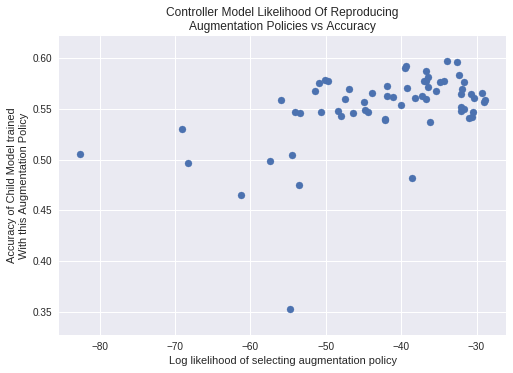

In [0]:
plt.scatter(x=np.log(newp), y=accuracies)
plt.ylabel('Accuracy of Child Model trained\nWith this Augmentation Policy')
plt.xlabel('Log likelihood of selecting augmentation policy')
plt.title('Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')

In [0]:
np.corrcoef(np.log(newp), accuracies)

array([[1.        , 0.49241823],
       [0.49241823, 1.        ]])